### Step 1: Initialise dependencies
 #### 0. Import all the required `libraries`

In [43]:
# Import libraries
import ipywidgets as widgets
from ipywidgets import HTML, interact, interactive
import markdown
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq

 #### 1. Choose file(s) to be processed

In [52]:
%run libraries/file-upload.ipynb

Button(description='File select', style=ButtonStyle())

SelectMultiple(description='Selected CSV files for processing', layout=Layout(width='90%'), options=(), style=…

#### 2. Open the data, in `CSV` format, and parse its contents into a `DataFrame`.

In [55]:
import csv

# Column names
time_raw = ('---', 'Time(s)')
column_time = 'Time(s)'
column_b = ('Analog In. | Ch.1', 'AIn-1 - Dem (AOut-1)')
column_c = ('Analog In. | Ch.1', 'AIn-1 - Dem (AOut-2)')

csv_data_df = pd.read_csv(fc_accumulator.options[0], header=[0, 1])
csv_data_df.drop(csv_data_df.filter(regex="Unnamed"), axis=1, inplace=True)
csv_data_df[column_time] = csv_data_df[time_raw]
csv_data_df.drop(csv_data_df.filter(regex='---'), axis=1, inplace=True)

# Subtract the `channel 2` from the `channel 1`
ft = 'F(t)'
csv_data_df[ft] = csv_data_df[column_b] - csv_data_df[column_c]

In [56]:
# Initialise all widgets
%run libraries/setup-widgets.ipynb

#### 3. Plot `F(t)`

In [59]:
csv_plot = csv_data_df.plot(x=column_time, y=ft, figsize=(40,10))
csv_plot.legend(loc='best')
csv_plot.set_xlim(f_min, f_max)
plt.show()

#### Exponential fit

R² = 0.8806479347396037


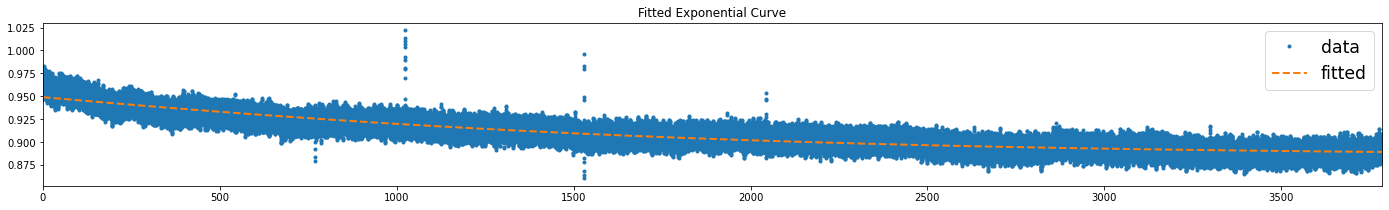

Y = 0.0984098380451584 * e^(-0.0008364809324792223 * x) + 0.7866960425234522
Tau = 59.774225638122324 µs


In [32]:
import scipy.optimize

def exponential_fit(x, m, t, b):
    return m * np.exp(scipy.special.expit(-t * x)) + b

# perform the fit
p0 = (0.970, 0.1, 1) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(exponential_fit, csv_data_df[column_time], csv_data_df[ft], p0)
m, t, b = params
sampleRate = 20_000_000 # Hz
tauSec = (1 / t) / sampleRate

# determine quality of the fit
squaredDiffs = np.square(csv_data_df[ft] - exponential_fit(csv_data_df[column_time], m, t, b))
squaredDiffsFromMean = np.square(csv_data_df[ft] - np.mean(csv_data_df[ft]))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# plot the results
plt.subplots(figsize = (24, 3))
plt.plot(csv_data_df[column_time], csv_data_df[ft], '.', label="data")
plt.plot(csv_data_df[column_time], exponential_fit(csv_data_df[column_time], m, t, b), '--', label="fitted", lw=2)
plt.xlim(f_min, f_max)
plt.title("Fitted Exponential Curve")
plt.legend(loc='best', fontsize='xx-large')
plt.show()
# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}")
print(f"Tau = {tauSec * 1e6} µs")

#### Extrapolating the Fitted Curve

In [33]:
xs2 = csv_data_df[column_time]
ys2 = exponential_fit(xs2, m, t, b)

plt.subplots(figsize = (24, 3))
plt.xlim(f_min, f_max)
plt.plot(xs2, ys2, '--', label="fitted", lw=2)
plt.title("Extrapolated Exponential Curve")
plt.legend(loc='best', fontsize='xx-large')
plt.show()

#### Constraining the Infinite Decay Value

In [34]:
def exponential_exp_ZeroB(x, m, t):
    return m * np.exp(scipy.special.expit(-t * x))

# perform the fit using the function where B is 0
p0 = (2000, 0.1) # start with values near those we expect
paramsB, cv = scipy.optimize.curve_fit(exponential_exp_ZeroB, csv_data_df[column_time], csv_data_df[ft], p0)
mB, tB = paramsB
sampleRate = 5_000_000 # Hz
tauSec = (1 / tB) / sampleRate

# inspect the results
print(f"Y = {mB} * e^(-{tB} * x)")
print(f"Tau = {tauSec * 1e6} µs")

# compare this curve to the original
ys_max = csv_data_df[ft].max()
ys_min = csv_data_df[ft].min()

print(len(xs2), len(ys2))
ys2B = exponential_exp_ZeroB(xs2, mB, tB)
plt.subplots(figsize = (24, 3))
plt.plot(csv_data_df[column_time], csv_data_df[ft], '.', label="data")
plt.plot(xs2, ys2, '--', label="fitted", lw=2)
plt.plot(xs2, ys2B, '--', label="zero B", lw=2)
plt.xlim(f_min, f_max)
plt.ylim(ys_min-ys_min/100, ys_max+ys_max/100)
plt.legend(loc='best', fontsize='xx-large')
plt.show()

Y = 0.9087426792639582 * e^(-24.53361866149315 * x)
Tau = 0.00815207910253822 µs
461420 461420


#### Apply fitting to `F(t)` resulting in `FF(t)`

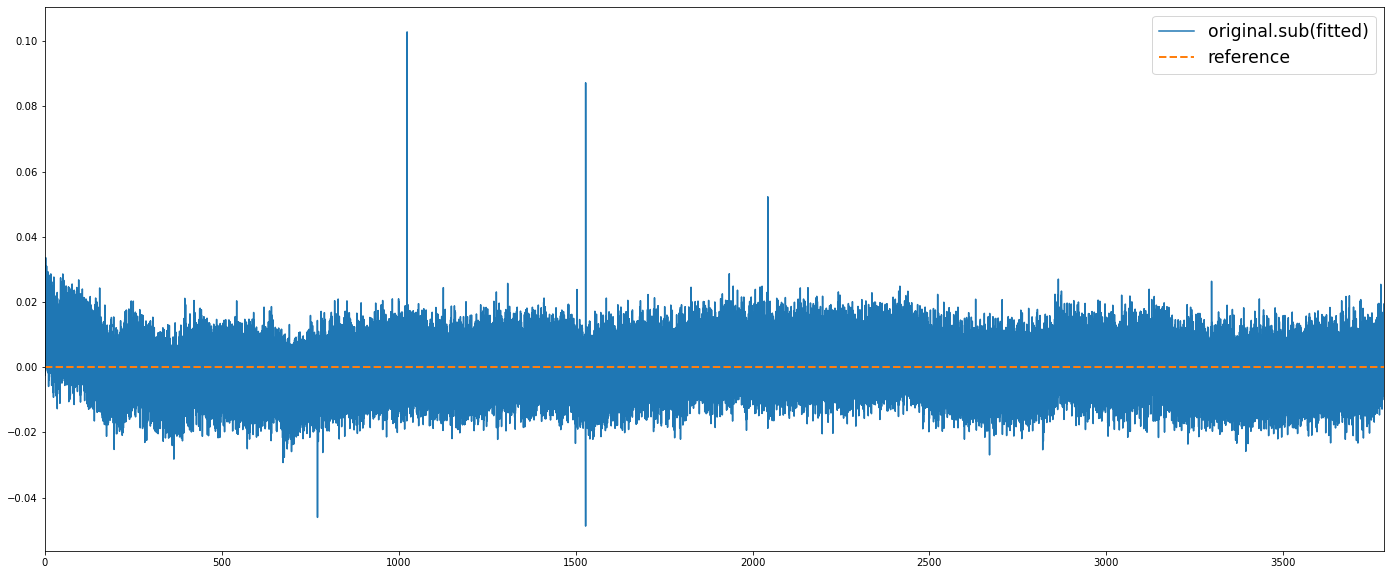

In [35]:
fitted_data = csv_data_df[[column_time, ft]].copy()
fitted_data[ft] = fitted_data[ft]-ys2

plt.subplots(figsize = (24, 10))
#plt.plot(csv_data_df[column_time], csv_data_df[ft], '-', label="original")
#plt.plot(xs2, ys2, '-', label="fitted", lw=4)
#plt.plot(xs2, fitted_data-ys2, '-', label="test", lw=4)
plt.plot(xs2, fitted_data[ft], '-', label='original.sub(fitted)')
plt.axhline(y=0, color='C1', linestyle='dashed', label='reference', lw=2)
plt.legend(loc='best', fontsize='xx-large')
plt.xlim(f_min,f_max)
#plt.ylim(0,0.1)
plt.show()

---

### Step 2: Compute `FF(0)`

#### Choose `FF(0)` range

In [36]:
windowed_data = fitted_data[fitted_data[column_time].between(f0_range.value[0], f0_range.value[1])]
f0 = windowed_data[ft].mean()

def update(s):
    windowed_data = fitted_data[fitted_data[column_time].between(f0_range.value[0], f0_range.value[1])]
    f0 = windowed_data[ft].mean()
    fmax = windowed_data[ft].max()
    plt.subplots(figsize = (24, 10))
    plt.plot(windowed_data[column_time], windowed_data[ft], label='F(0)')
    plt.xlim(s[0], s[1])
    plt.axhline(y=0, color='C1', linestyle='dashed', label='reference', lw=2)
    plt.annotate('F(0): %.20f' % f0, (s[0]+(s[1]-s[0])/50, fmax-fmax/300), color='#eb4034', fontsize='xx-large')

    plt.show()
interact(update, s=f0_range)

interactive(children=(IntRangeSlider(value=(1261, 1892), description='<b>F(0) range</b>', layout=Layout(width=…

<function __main__.update(s)>

---

### Step 3: Compute `FF'(t)`

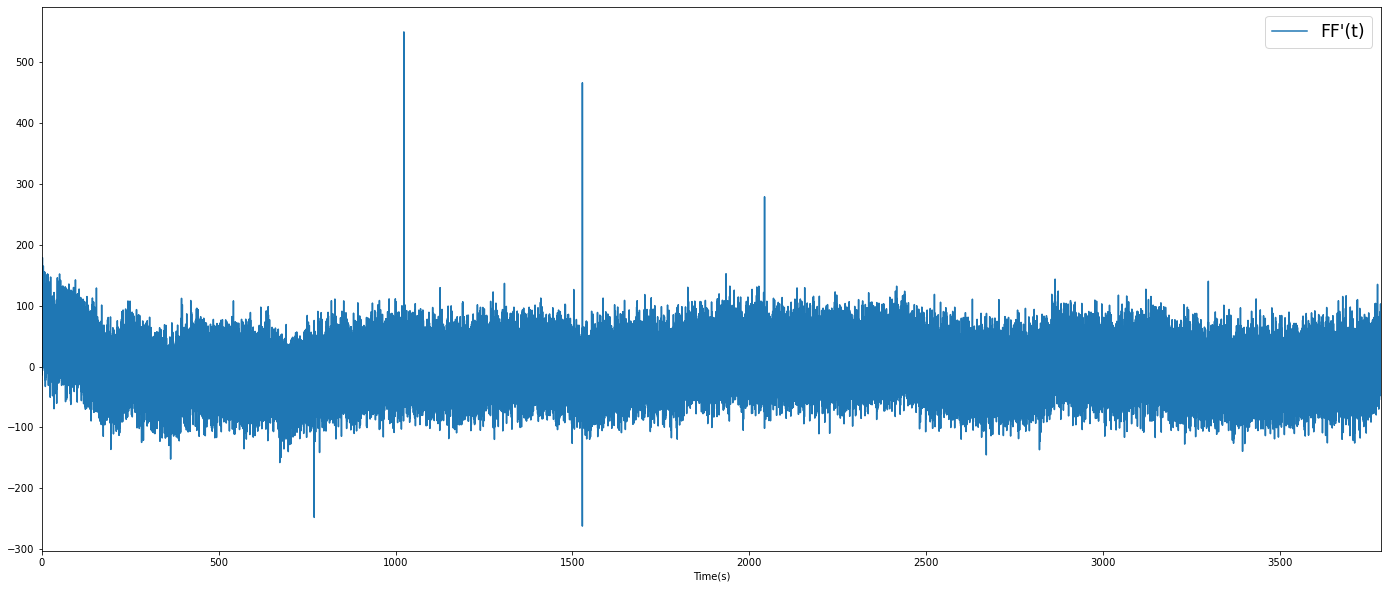

In [37]:
fdt = fitted_data.copy()
fdt[ft] = fdt[ft].apply(lambda x: (x - f0) / f0)
fdt.plot(column_time, ft, label="FF'(t)", figsize = (24, 10))
plt.xlim(f_min, f_max)
plt.legend(loc='best', fontsize='xx-large')
plt.show()

#### Low-Pass filter controls

In [38]:
%run libraries/lpf-controls.ipynb

#### `Filter FF'(t)` + `Heatmap` + `Low-Pass Filter` + `Z-Score` + `Peak detection`

In [39]:
%run libraries/lpf-controls.ipynb
interact(gen_filtered_fft, sampling=butter_filter_sampling_freq, cutoff=butter_filter_cutoff, window=filtered_fdt_window, peak=peak_height_threshold)

interactive(children=(IntText(value=100, continuous_update=True, description='LPF <b>sampling</b>'), FloatSlid…

<function __main__.gen_filtered_fft(sampling, cutoff, window, peak)>

---

---

### Controls

In [40]:
html = markdown.markdown('## Export')
display(HTML(html),
        export_csv_dtf_button,
        export_graphpad_dtf_button)

HTML(value='<h2>Export</h2>')

Button(description="Filtered FF'(t) to CSV", style=ButtonStyle())

Button(description="Filtered FF'(t) to GraphPad", style=ButtonStyle())